In [1]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
%matplotlib inline

In [2]:
#importing the csv files
features = pd.read_csv('Features data set.csv')
sales = pd.read_csv('sales data-set.csv')
stores = pd.read_csv('stores data-set.csv')

### Some cleanup

In [3]:
#changing Date column to datetime datatype
features['Date'] = pd.to_datetime(features['Date'])
sales['Date'] = pd.to_datetime(sales['Date'])

In [4]:
#merging the dataframes
data = pd.merge(sales, features, on=['Store','Date', 'IsHoliday'], how='left')
data = pd.merge(data, stores, on=['Store'], how='left')

In [5]:
#checking for nulls and filling with 0 since they are relation to promotions in certain stores
data.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [6]:
data = data.fillna(0)

In [7]:
data.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

### EDA

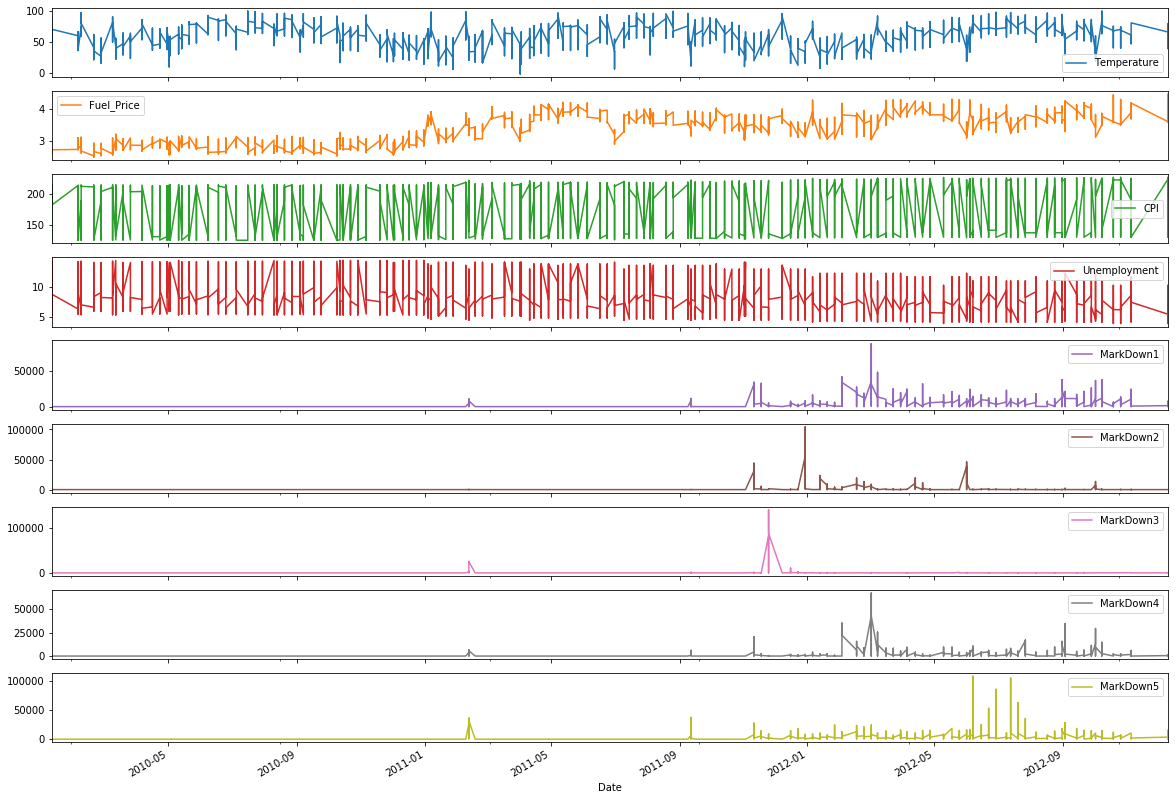

In [8]:
#plotting some variables
data[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].plot(x='Date', subplots=True, figsize=(20,15))
plt.show()

          Date  Weekly_Sales
46  2010-12-24   80931415.60
98  2011-12-23   76998241.31
95  2011-11-25   66593605.26
41  2010-11-26   65821003.24
45  2010-12-17   61820799.85
97  2011-12-16   60085695.94
35  2010-10-12   55666770.39
83  2011-09-12   55561147.70
120 2012-06-04   53502315.87
121 2012-06-07   51253021.88


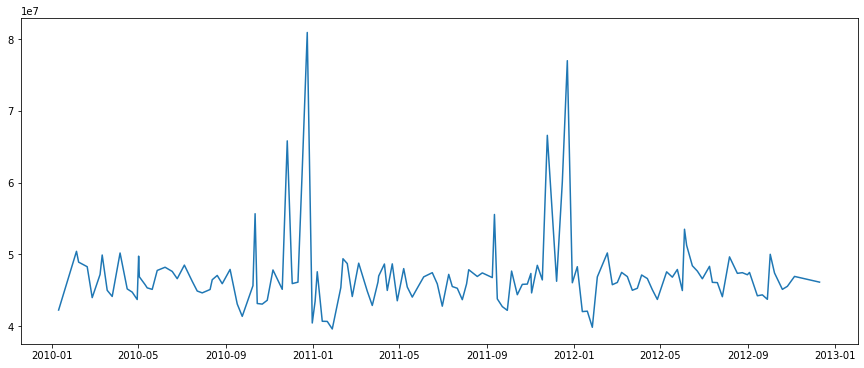

In [9]:
#Average Sales for all store/department for Week
average_sales_week = data.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
average_sales = average_sales_week.sort_values('Weekly_Sales', ascending=False)

print(average_sales[:10])

#Seasonality vs Trend Analysis
plt.figure(figsize=(15,6))
plt.plot(average_sales_week.Date, average_sales_week.Weekly_Sales)
plt.show()

   IsHoliday  Weekly_Sales
0      False  6.231919e+09
1       True  5.052996e+08


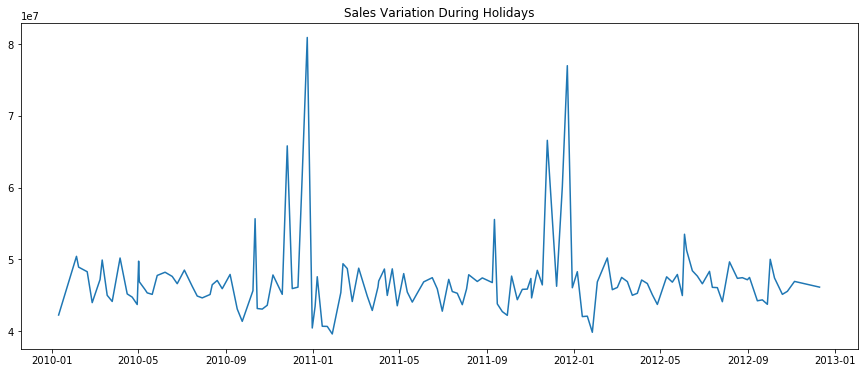

In [10]:
#Sales variation during Holidays(Store/Dept)
holiday =  data[['Date', 'IsHoliday', 'Weekly_Sales']].copy()
holiday =  holiday.groupby(by=['Date','IsHoliday'], as_index=False)['Weekly_Sales'].sum()
holiday_group =  holiday.groupby(by=['IsHoliday'], as_index=False)['Weekly_Sales'].sum()
print( holiday_group)


plt.figure(figsize=(15,6))
plt.title('Sales Variation During Holidays')
plt.plot(holiday.Date, holiday.Weekly_Sales)
plt.show()

Text(0.5, 1, 'Correlation Heatmap')

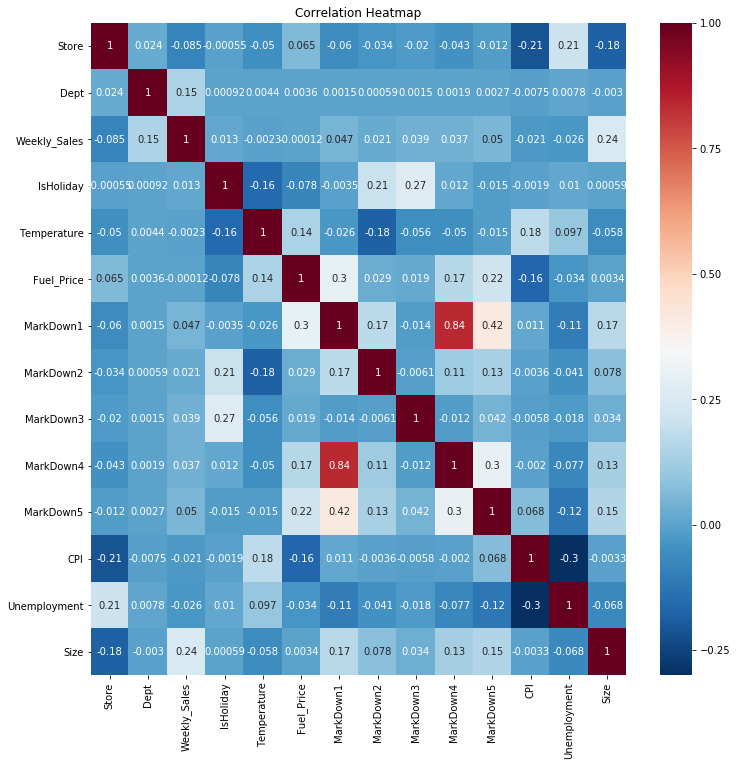

In [11]:
#correlation heatmap
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(),annot=True,cmap='RdBu_r')
plt.title('Correlation Heatmap')

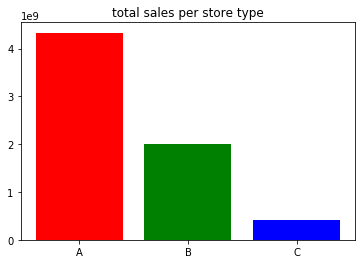

In [12]:
# Top performing type of stores in term of sales
top_stores = data.groupby(by=['Type'], as_index=False)['Weekly_Sales'].sum()
top_stores = top_stores.sort_values('Weekly_Sales', ascending=False)
plt.bar(top_stores.Type, top_stores.Weekly_Sales, color='rgb')
plt.title('total sales per store type')
plt.show()

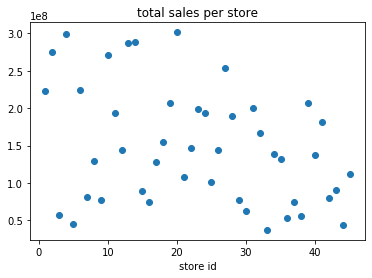

In [13]:
# Top performing stores in term of sales
top_stores = data.groupby(by=['Store'], as_index=False)['Weekly_Sales'].sum()
top_stores = top_stores.sort_values('Weekly_Sales', ascending=False)
plt.scatter(top_stores.Store, top_stores.Weekly_Sales)
plt.title('total sales per store')
plt.xlabel('store id')
plt.show()

### Forecasting

In [14]:
ts = average_sales_week.set_index('Date')
ts = ts.resample('W').ffill()

C:\Users\mcand\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


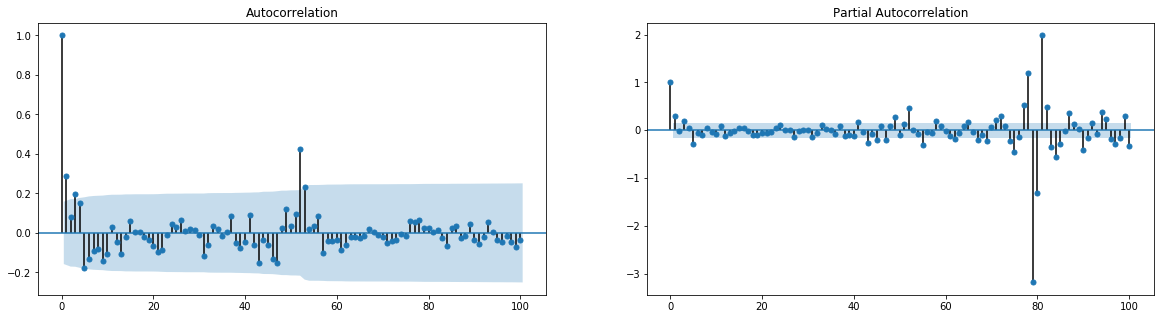

In [15]:
#plottign acf, pacf
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(ts, lags=100, ax=axes[0])
plot_pacf(ts, lags=100, ax=axes[1])
plt.show()

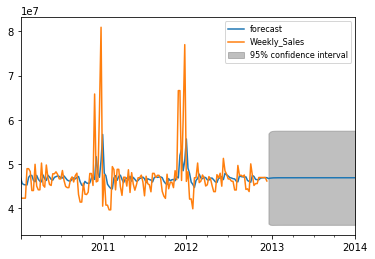

In [16]:
#forecast based on weekly sales and date
mod = ARMA(ts, order=(1,1))
res = mod.fit()

res.plot_predict(start=0, end='2014')
plt.legend(fontsize=8)
plt.show()


In [17]:
#Forecast of the store-wise sales volume
#Develop the forecast model for the store number 20, which shows the highest sales volume.
store20 = data.where( data['Store'] == 20)
store20 = store20.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
store20 = store20.set_index('Date')
store20.resample('W').ffill()
store20.head()

,Weekly_Sales
Date,
2010-01-10,1933719.21
2010-02-04,2405395.22
2010-02-07,2143676.77
2010-02-19,2161549.76
2010-02-26,1898193.95


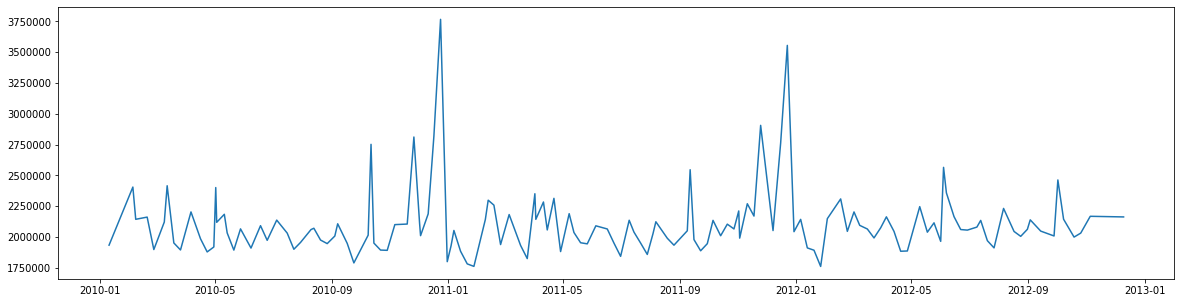

In [18]:
plt.figure(figsize=(20,5))
plt.plot(store20.index, store20.values)
plt.show()

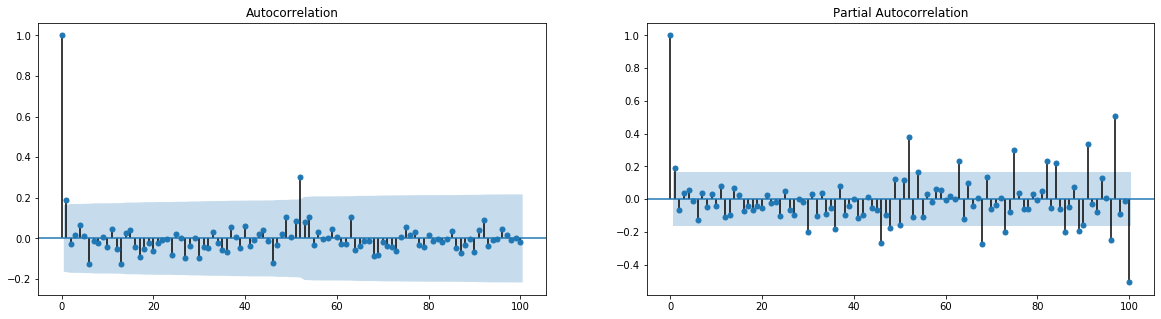

In [19]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(store20.values, lags=100, alpha=0.05, ax=axes[0])
plot_pacf(store20.values, lags=100, alpha=0.05, ax=axes[1])
plt.show()

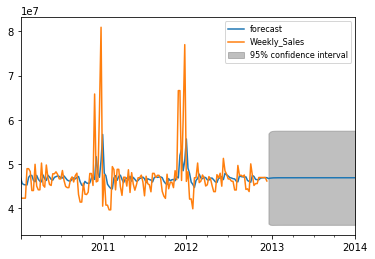

In [20]:
#forecast based on weekly sales and date
mod = ARMA(ts, order=(1,1))
res = mod.fit()

res.plot_predict(start=0, end='2014')
plt.legend(fontsize=8)
plt.show()

### Conclusion

While long-term forecasts that give large, established organizations a view of the future remain important, rapid change and the increasing importance of small and medium-sized high-growth organizations probably has reduced the use of long-range projections. 

in this project, I would recommend working on the sales of other stores as some are doing much better than others. the highest sales store seem to be doing well when forecasting a year in the future.